# ANOVA Decomposition

The [*analysis of variances (ANOVA) decomposition*](http://www.broda.co.uk/gsa/sobol_global_sa.pdf) is well-defined for any square-integrable multidimensional function $f: \mathbb{R}^N \to \mathbb{R}$. If the input variables $\{x_0, \dots, x_{N-1}\}$ are independently distributed random variables, the ANOVA decomposition partitions the total variance of the model, $\mathrm{Var}[f]$, as a sum of variances of orthogonal functions $\mathrm{Var}[f_{\alpha}]$ for all possible subsets $\alpha$ of the input variables. Each $f_{\alpha}$ depends effectively on the variables contained in $\alpha$ only, and is constant with respect to the rest.

In [1]:
import torch
import tntorch as tn

N = 4
t = tn.rand([32]*N, ranks_tt=5)

Let's compute all ANOVA terms in one single tensor network:

In [2]:
anova = tn.anova_decomposition(t)
anova

4D TT-Tucker tensor:

 33  33  33  33
  |   |   |   |
 32  32  32  32
 (0) (1) (2) (3)
 / \ / \ / \ / \
1   5   5   5   1

This tensor `anova` indexes *all* $2^N$ functions $f_{\alpha}$ of the ANOVA decomposition of $f$, and we can access it using our [tensor masks](https://github.com/rballester/tntorch/blob/master/tutorials/logic.ipynb).

Reference: [*"Sobol Tensor Trains for Global Sensitivity Analysis"*](https://arxiv.org/abs/1712.00233), R. Ballester-Ripoll, E. G. Paredes, R. Pajarola (2017).

### Manipulating the Decomposition

For example, let's keep all terms that *do not* interact with $w$:

In [3]:
x, y, z, w = tn.symbols(N)
anova_cut = tn.mask(anova, ~w)

We can undo the decomposition to obtain a regular tensor again:

In [4]:
t_cut = tn.undo_anova_decomposition(anova_cut)

As expected, our truncated tensor `t_cut` has become constant with respect to the fourth variable $w$:

In [5]:
t_cut[0, 0, 0, :].full()

tensor([9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524,
        9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524,
        9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524, 9.9524,
        9.9524, 9.9524, 9.9524, 9.9524, 9.9524])

How much did we lose by making that variable unimportant?

In [6]:
print('The truncated tensor accounts for {:g}% of the original variance.'.format(tn.var(t_cut) / tn.var(t) * 100))

The truncated tensor accounts for 67.7053% of the original variance.


... which is also what [Sobol's method](https://github.com/rballester/tntorch/blob/master/tutorials/sobol.ipynb)) gives us:

In [7]:
tn.sobol(t, ~w) * 100

tensor(67.7053)

or, equivalently,

In [8]:
tn.sobol(t, tn.only(x | y | z)) * 100

tensor(67.7053)

### Truncating Dimensionality

The low-dimensional terms of the ANOVA decomposition (i.e. terms that depend on a few variables only) are usually the ones that play the most important role in many analytical and real-world models.

We will now approximate our original function as a sum of (at most) bivariate functions. To that end we will use a [weight mask tensor](https://github.com/rballester/tntorch/blob/master/tutorials/logic.ipynb).

In [9]:
m = tn.weight_mask(N, [0, 1, 2])  # Keep tuples with zero, one or two '1's
print('We will keep only {:g} of the original ANOVA terms'.format(tn.sum(m)))
t_cut = tn.undo_anova_decomposition(tn.mask(tn.anova_decomposition(t), m))
print('Relative error after truncation: {}'.format(tn.relative_error(t, t_cut)))

We will keep only 11 of the original ANOVA terms
Relative error after truncation: 0.03178443381317379


### Visualizing the ANOVA Decomposition

Let's now restrict ourselves to $N = 2$ so that we can easily plot the ANOVA subfunctions and get an idea how they look like.

In [10]:
# We set up a smooth 2D tensor, sum of a few cosine wavefunctions
N = 2
t = tn.randn([64]*N, ranks_tt=4, ranks_tucker=3)
t.set_factors('dct')
t

2D TT-Tucker tensor:

 64  64
  |   |
  3   3
 (0) (1)
 / \ / \
1   4   1

First we will show the full function:

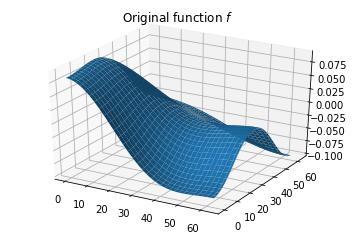

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.arange(t.shape[0]), np.arange(t.shape[1]))
surf = ax.plot_surface(X, Y, t.numpy())
plt.title('Original function $f$')
plt.show()

Next we will show the $2^N = 4$ ANOVA subfunctions:

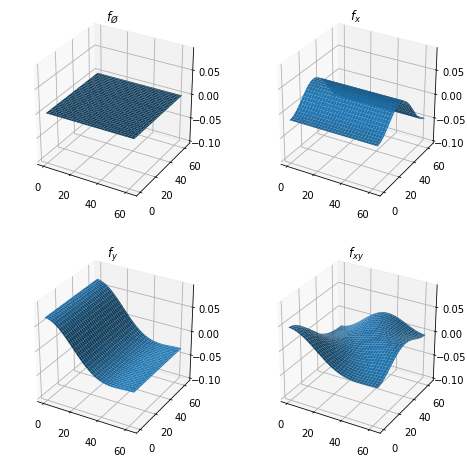

In [12]:
x, y = tn.symbols(N)
anova = tn.anova_decomposition(t)
X, Y = np.meshgrid(np.arange(t.shape[0]), np.arange(t.shape[1]))
zlim = [t.numpy().min(), t.numpy().max()]

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(X, Y, tn.undo_anova_decomposition(tn.mask(anova, tn.false(N))).numpy())
ax.set_zlim3d(zlim[0], zlim[1])
ax.set_title('$f_{\O}$')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(X, Y, tn.undo_anova_decomposition(tn.mask(anova, tn.only(x))).numpy())
ax.set_zlim3d(zlim[0], zlim[1])
ax.set_title('$f_x$')

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(X, Y, tn.undo_anova_decomposition(tn.mask(anova, tn.only(y))).numpy())
ax.set_zlim3d(zlim[0], zlim[1])
ax.set_title('$f_y$')

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X, Y, tn.undo_anova_decomposition(tn.mask(anova, tn.only(x & y))).numpy())
ax.set_zlim3d(zlim[0], zlim[1])
ax.set_title('$f_{xy}$')

plt.show()